# Purpose:
- I'm using skewness of dF to filter tdTomato-only ROIs from JK052
- There are sessions (e.g., S014 for lower volume of JK052) where huge signal error leads to too high skewness values compared to other sessions.
- Correct skew values using reduced fluorescence for select sessions
    - For all JK052 sessions
    - dF = F_reduced - ops['neucoeff'] * Fneu_reduced
- Actually, re-calculate skew and save them to stat_reduced for all mice and sessions

In [7]:
import numpy as np
import pandas as pd
from scipy import stats
from pathlib import Path
from matplotlib import pyplot as plt

In [3]:

base_dir = Path(r'E:\TPM\JK\h5')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]


In [5]:
# Test in one session
mouse = 52
plane = 1
session_num = 3
session_name = f'{session_num:03}'
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
roi_dir = plane_dir / f'{session_name}/plane0/roi'
ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
stat = np.load(roi_dir / 'stat.npy', allow_pickle=True)
F_reduced = np.load(roi_dir / 'F_reduced.npy')
Fneu_reduced = np.load(roi_dir / 'Fneu_reduced.npy')
assert F_reduced.shape == Fneu_reduced.shape
assert F_reduced.shape[0] == len(stat)
dF = F_reduced - ops['neucoeff'] * Fneu_reduced
sk = stats.skew(dF, axis=1)



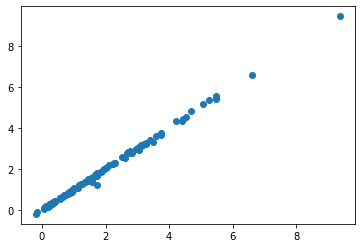

In [8]:
skew_from_stats = np.array([s['skew'] for s in stat])
fig, ax = plt.subplots()
ax.scatter(skew_from_stats, sk)

False


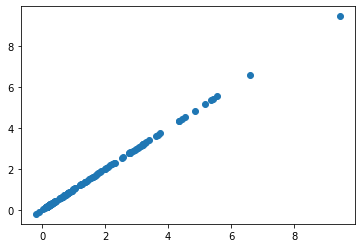

In [11]:
for i, s in enumerate(stat):
    s['skew'] = sk[i]
skew_from_stats_reduced = np.array([s['skew'] for s in stat])
fig, ax = plt.subplots()
ax.scatter(skew_from_stats_reduced, sk)
print((skew_from_stats_reduced - sk).any())

In [14]:
row = use_mice_df.iloc[0]
row.session

'001'

In [16]:
from tqdm.notebook import tqdm
for _, row in tqdm(use_mice_df.iterrows()):
    mouse = row.mouse
    plane = row.plane
    session_name = row.session
    plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
    roi_dir = plane_dir / f'{session_name}/plane0/roi'
    if not roi_dir.exists():
        print(f'{roi_dir} does not exist')
        continue
    ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
    stat = np.load(roi_dir / 'stat.npy', allow_pickle=True)
    F_reduced = np.load(roi_dir / 'F_reduced.npy')
    Fneu_reduced = np.load(roi_dir / 'Fneu_reduced.npy')
    assert F_reduced.shape == Fneu_reduced.shape
    assert F_reduced.shape[0] == len(stat)
    dF = F_reduced - ops['neucoeff'] * Fneu_reduced
    sk = stats.skew(dF, axis=1)
    for i, s in enumerate(stat):
        s['skew'] = sk[i]
    np.save(roi_dir / 'stat_reduced.npy', stat)
# 6m 18.7s for all the sessions

0it [00:00, ?it/s]

# The high skew in JK052 S014 lower volume is still there
- check the traces

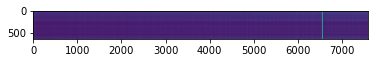

In [17]:
mouse = 52
plane = 5
session_name = '014'
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
roi_dir = plane_dir / f'{session_name}/plane0/roi'
F = np.load(roi_dir / 'F_reduced.npy')
fig, ax = plt.subplots()
ax.imshow(F)

## F_reduced is not enough
- Need to remove frames from error check (refined_frame_time.pkl)
    - (from 231209_manual_trial_removal.ipynb)

In [18]:
frame_time_df = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')
frame_time_df.head()

,trialNum,frame_start_time,frame_end_time,trial_duration,frame_index,remove_frame,remove_trial
0,7,0.317710,0.350140,8.395944,1,False,False
1,7,0.447429,0.479859,8.395944,2,False,False
2,7,0.577148,0.609578,8.395944,3,False,False
3,7,0.706867,0.739297,8.395944,4,False,False
4,7,0.836586,0.869015,8.395944,5,False,False


In [21]:
np.setdiff1d(np.where(frame_time_df['remove_trial'])[0],
                np.where(frame_time_df['remove_frame'])[0])

array([6523, 6524, 6525, 6526, 6527, 6528, 6529, 6530, 6531, 6532, 6533,
       6534, 6535, 6536, 6537, 6538, 6539, 6540, 6541, 6542, 6543, 6544,
       6545, 6546, 6547, 6548, 6549, 6566], dtype=int64)

In [22]:
np.setdiff1d(np.where(frame_time_df['remove_frame'])[0],
                np.where(frame_time_df['remove_trial'])[0])

array([], dtype=int64)

In [24]:
frame_time_df.query('remove_trial == False').frame_index.values

array([1, 2, 3, ..., 8075, 8076, 8077], dtype=object)

In [25]:
F.shape

(642, 7599)

In [26]:
len(frame_time_df)

7599

# Generate stat_refined.npy
- using refined_frame_time.pkl
- choose remove_trial column

In [28]:
from tqdm.notebook import tqdm
for _, row in tqdm(use_mice_df.iterrows()):
    mouse = row.mouse
    plane = row.plane
    session_name = row.session
    plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
    roi_dir = plane_dir / f'{session_name}/plane0/roi'
    if not roi_dir.exists():
        print(f'{roi_dir} does not exist')
        continue
    ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
    stat_reduced = np.load(roi_dir / 'stat_reduced.npy', allow_pickle=True)
    F_reduced = np.load(roi_dir / 'F_reduced.npy')
    Fneu_reduced = np.load(roi_dir / 'Fneu_reduced.npy')
    assert F_reduced.shape == Fneu_reduced.shape
    assert F_reduced.shape[0] == len(stat_reduced)
    dF = F_reduced - ops['neucoeff'] * Fneu_reduced

    frame_time_df = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')
    if frame_time_df['remove_frame'].any():
        refined_frame_index = np.where(frame_time_df['remove_trial'] == False)[0]
        dF = dF[:,refined_frame_index]

        sk = stats.skew(dF, axis=1)
        for i, s in enumerate(stat_reduced):
            s['skew'] = sk[i]
    np.save(roi_dir / 'stat_refined.npy', stat_reduced)

# 3m for all the sessions

0it [00:00, ?it/s]

In [31]:
# for mouse 52, plane 1-4, session 013
mouse = 52
session_name = '013'
for plane in range(1,5):
    plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
    roi_dir = plane_dir / f'{session_name}/plane0/roi'
    if not roi_dir.exists():
        print(f'{roi_dir} does not exist')
        continue
    ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
    stat_reduced = np.load(roi_dir / 'stat_reduced.npy', allow_pickle=True)
    F_reduced = np.load(roi_dir / 'F_reduced.npy')
    Fneu_reduced = np.load(roi_dir / 'Fneu_reduced.npy')
    assert F_reduced.shape == Fneu_reduced.shape
    assert F_reduced.shape[0] == len(stat_reduced)
    dF = F_reduced - ops['neucoeff'] * Fneu_reduced

    frame_time_df = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')
    if frame_time_df['remove_frame'].any():
        print(f'{roi_dir} has removed frames')
        refined_frame_index = np.where(frame_time_df['remove_trial'] == False)[0]
        dF = dF[:,refined_frame_index]

        sk = stats.skew(dF, axis=1)
        for i, s in enumerate(stat_reduced):
            s['skew'] = sk[i]
    np.save(roi_dir / 'stat_refined.npy', stat_reduced)

E:\TPM\JK\h5\052\plane_1\013\plane0\roi has removed frames
E:\TPM\JK\h5\052\plane_2\013\plane0\roi has removed frames
E:\TPM\JK\h5\052\plane_3\013\plane0\roi has removed frames
E:\TPM\JK\h5\052\plane_4\013\plane0\roi has removed frames
